# Analyzing MLP in Transformer-based Decision Making

This notebook explores the Multi-Layer Perception mechanisms in transformer models trained on decision sequences. We'll visualize and analyze what is represented in the Multi-Layer Perceptrons that lead to decision-making outputs (R, r, L, l).


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
import utils.file_management as fm
from transformer.transformer import MLP
# from utils.parse_data import parse_simulated_data, get_data_filenames, add_sequence_columns
# from interpretability.interp_helpers import tokenize
from interpretability import interp_helpers as interp
from interpretability import activations as act
from interpretability.activations import MLPAnalyzer
from interpretability.analyzer import DimensionalityReductionConfig
%load_ext autoreload
%autoreload 2


In [3]:
sns.set_theme(style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 10,
        'axes.titlesize': 10,
        'savefig.transparent': True,
        'legend.title_fontsize': 10,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 10,
        'figure.subplot.wspace': 0.1,
        })

In [36]:
run = 1 # 36

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# Load the model
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

# Print model configuration details
print(f"Number of layers: {config.n_layer}")
print(f"Number of attention heads: {config.n_head}")
print(f"Embedding dimension: {config.n_embd}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Block size (context length): {config.block_size}")

# Create a dummy MLP for analysis
dummy_mlp = MLP(config)

# Analyze MLP dimensions
mlp_input_dim = dummy_mlp.c_fc.in_features
mlp_hidden_dim = dummy_mlp.c_fc.out_features
mlp_output_dim = dummy_mlp.c_proj.out_features

print(f"\nMLP Dimensions Analysis:")
print(f"MLP Input Dimension: {mlp_input_dim}")
print(f"MLP Hidden Dimension: {mlp_hidden_dim}")
print(f"MLP Output Dimension: {mlp_output_dim}")

Using cpu device
Total number of parameters: 292
Number of layers: 1
Number of attention heads: 1
Embedding dimension: 4
Vocabulary size: 4
Block size (context length): 6

MLP Dimensions Analysis:
MLP Input Dimension: 4
MLP Hidden Dimension: 16
MLP Output Dimension: 4


In [37]:
# Analyze MLP parameters
mlp_params = sum(p.numel() for p in dummy_mlp.parameters() if p.requires_grad)
print(f"\nMLP Parameters: {mlp_params}")

# Detailed breakdown of MLP parameters
fc_params = dummy_mlp.c_fc.weight.numel() + (dummy_mlp.c_fc.bias.numel() if dummy_mlp.c_fc.bias is not None else 0)
proj_params = dummy_mlp.c_proj.weight.numel() + (dummy_mlp.c_proj.bias.numel() if dummy_mlp.c_proj.bias is not None else 0)

print(f"First linear layer (c_fc) parameters: {fc_params}")
print(f"  - Weight shape: {dummy_mlp.c_fc.weight.shape}")
print(f"  - Bias shape: {dummy_mlp.c_fc.bias.shape if dummy_mlp.c_fc.bias is not None else 'None'}")
print(f"Projection layer (c_proj) parameters: {proj_params}")
print(f"  - Weight shape: {dummy_mlp.c_proj.weight.shape}")
print(f"  - Bias shape: {dummy_mlp.c_proj.bias.shape if dummy_mlp.c_proj.bias is not None else 'None'}")

# Calculate percentage of parameters in MLP vs. total model
mlp_percentage = (mlp_params * config.n_layer / total_params) * 100

print(f"Each transformer block contains one MLP")
print(f"Total MLPs in model: {config.n_layer}")
print(f"Total parameters in all MLPs: {mlp_params * config.n_layer}")
print(f"MLPs account for {mlp_percentage:.2f}% of total model parameters")


MLP Parameters: 148
First linear layer (c_fc) parameters: 80
  - Weight shape: torch.Size([16, 4])
  - Bias shape: torch.Size([16])
Projection layer (c_proj) parameters: 68
  - Weight shape: torch.Size([4, 16])
  - Bias shape: torch.Size([4])
Each transformer block contains one MLP
Total MLPs in model: 1
Total parameters in all MLPs: 148
MLPs account for 50.68% of total model parameters


# 1. Extract MLP activations for different sequences


In [38]:
T = model_info['dataloader']['Sequence length (T)']
print(f"Sequence length: {T}")

# Get common sequences from data for analysis
num_sequences = 300
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

tokenized_sequences = interp.tokenize(sequences)
logits, loss = model(tokenized_sequences)
probs = F.softmax(logits[:, -1, :], dim=1)
max_probs, predicted_token = probs.max(dim=1)#.detach().cpu().numpy()

Sequence length: 6


Analyzing 300 sequences:
['RRRRRR', 'LLLLLL', 'LLLLLl', 'RRRRRr', 'RRRRrR', 'LLLLlL', 'RRRrRR', 'LLLlLL', 'RRrRRR', 'RrRRRR', 'LLlLLL', 'LlLLLL', 'rRRRRR', 'lLLLLL', 'rLLLLL', 'lRRRRR', 'rrLLLL', 'llRRRR', 'LLLLll', 'RRRRrr']


In [39]:
analyzer = MLPAnalyzer(model, config)

In [40]:
# Collect MLP activations for each sequence as (mlp_input_dim=nneurons x T)
activations = analyzer.get_activations(sequences)

# 2. Analyze which neurons are most active for different decisions

# 3. Analyze neuron specialization - do certain neurons always activate for R vs L?

In [41]:
# Extract last token position activations for each layer
last_pos_by_layer = analyzer.get_activation_by_position(activations, token_pos=-1)

# Find the most active neurons for each sequence
top_neurons = {}
for seq, act in last_pos_by_layer['input'].items():
    # Get top 5 neurons with highest activation
    top_idx = np.argsort(act)[-5:]
    top_values = act[top_idx]
    top_neurons[seq] = list(zip(top_idx, top_values))

# print("Top active neurons for each sequence:")
# for seq, neurons in top_neurons.items():
#     print(f"{seq}: {neurons}")

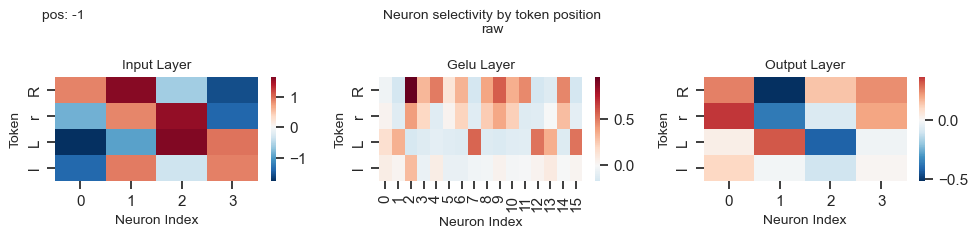

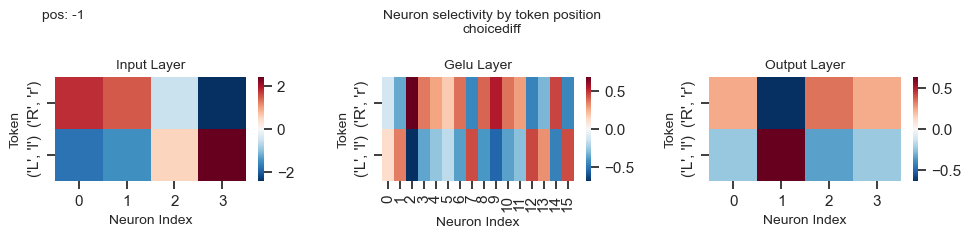

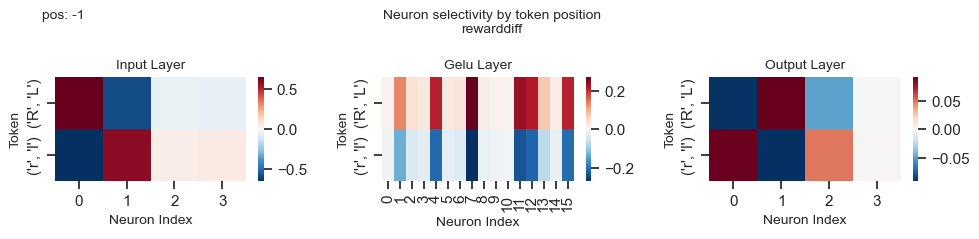

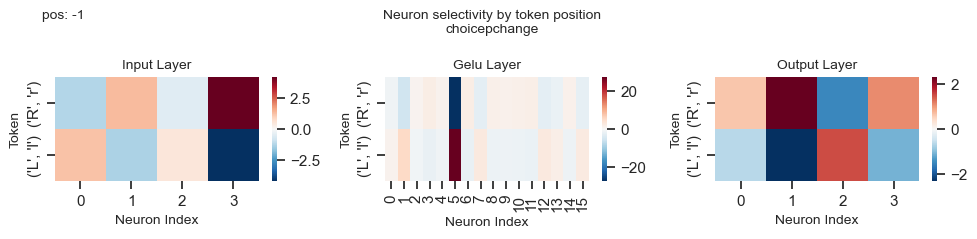

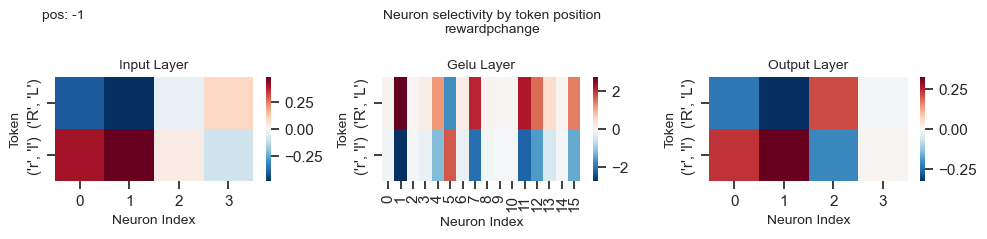

In [42]:
for method in ['raw', 'choicediff', 'rewarddiff', 'choicepchange', 'rewardpchange']:
    selectivity_response, fig = analyzer.analyze_layer_specialization(activations, token_pos=-1, method=method)
    fig_path = fm.get_experiment_file(f'mlp_selectivity_last_token_{method}.png', run, subdir=f'interp')
    fig.savefig(fig_path, bbox_inches='tight')


# 5. Cluster Sequences by Activation Patterns

In [43]:
dr_config = DimensionalityReductionConfig(
    token_pos=-1,
    sequence_method='token',
    n_components=4
)

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:371: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:371: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(


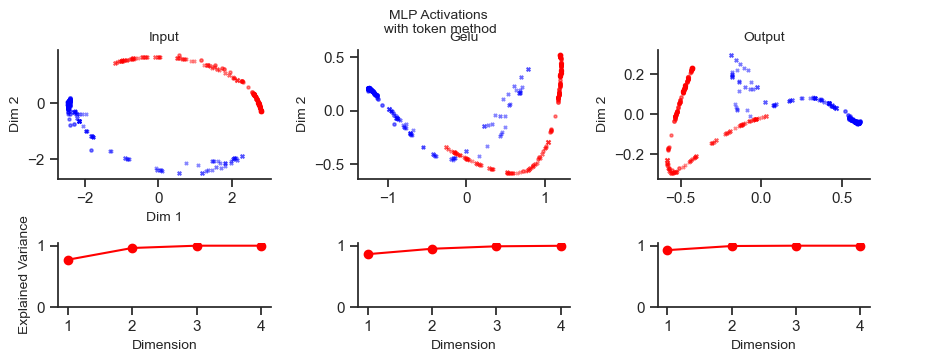

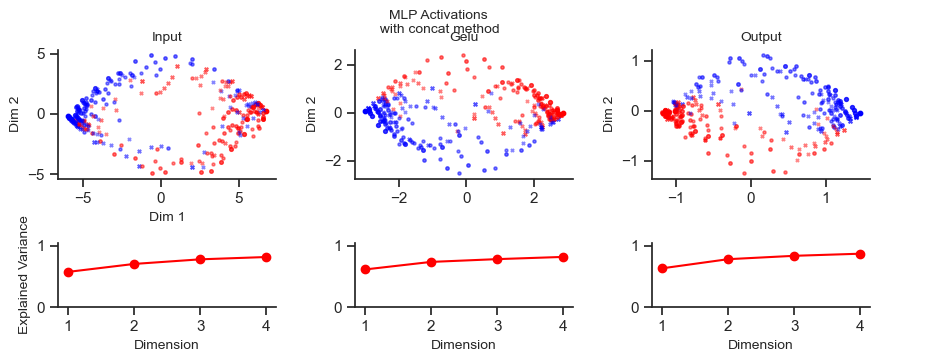

In [44]:
for sm in ['token', 'concat']:
    dr_config.sequence_method = sm
    fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences, dr_config, counts=counts)
    fig_path = fm.get_experiment_file(f'mlp_pca_{sm}.png', run, subdir=f'interp')
    fig.savefig(fig_path, bbox_inches='tight')

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:371: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/analyzer.py:371: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(


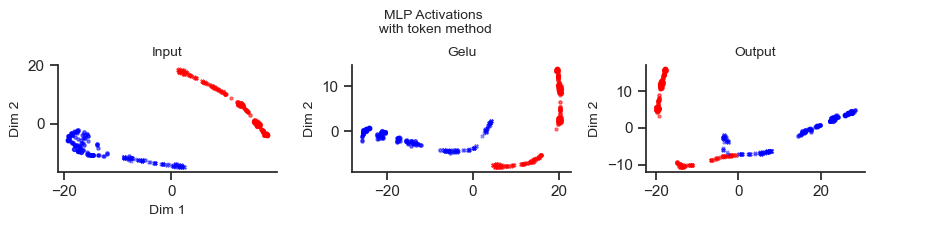

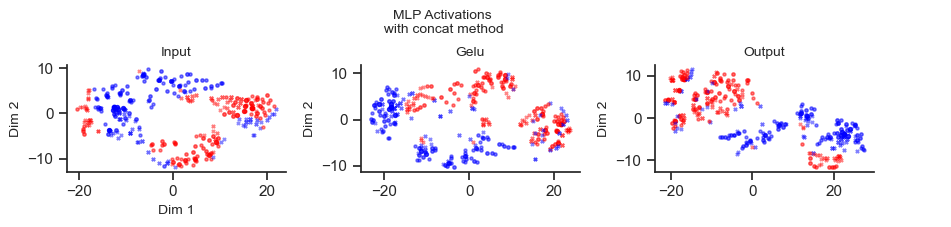

In [45]:
dr_config.method = 'tsne'

for sm in ['token', 'concat']:
    dr_config.sequence_method = sm
    fig, axs = analyzer.visualizer.plot_pca_by_layer(sequences, dr_config, counts=counts, variance_explained=False)
    fig_path = fm.get_experiment_file(f'mlp_tsne_{sm}.png', run, subdir=f'interp')
    fig.savefig(fig_path, bbox_inches='tight')

In [46]:
events.query('high_port == 1')['k0'].value_counts()

k0
R    383215
l     66107
r     42320
L      7376
Name: count, dtype: int64

In [47]:
block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)
block_sequences = [list(b.values) for b in block_sequences]

KeyboardInterrupt: 

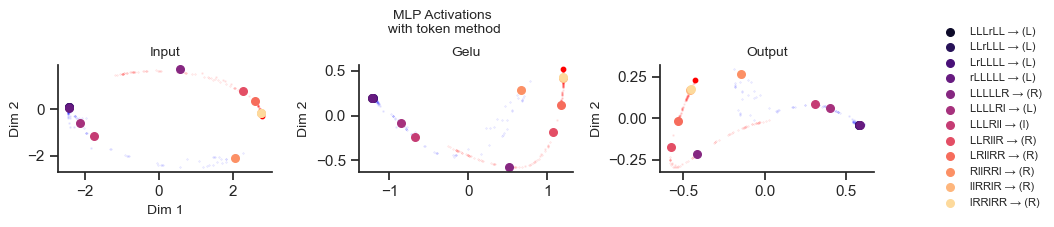

In [52]:
dr_config = DimensionalityReductionConfig(
    token_pos=-1,
    sequence_method='token',
    n_components=4
)
for i, seq in enumerate(block_sequences[10:14], start=10):
    fig, axs = analyzer.visualizer.plot_pca_across_trials(sequences, seq, ['input', 'gelu', 'output'], dr_config)
    fig_path = fm.get_experiment_file(f'mlp_pca_last_token.png', run, subdir=f'interp/bt_{i}')
    fig.savefig(fig_path, bbox_inches='tight')

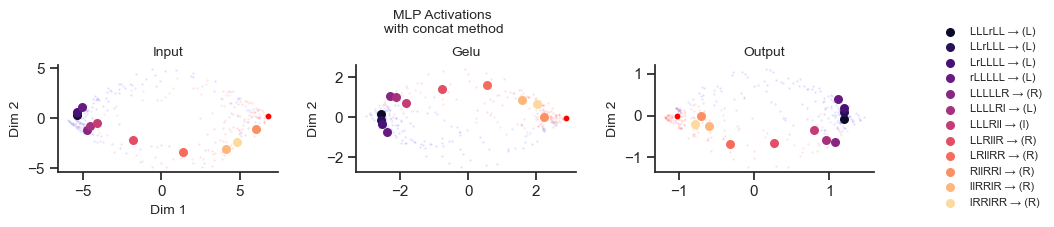

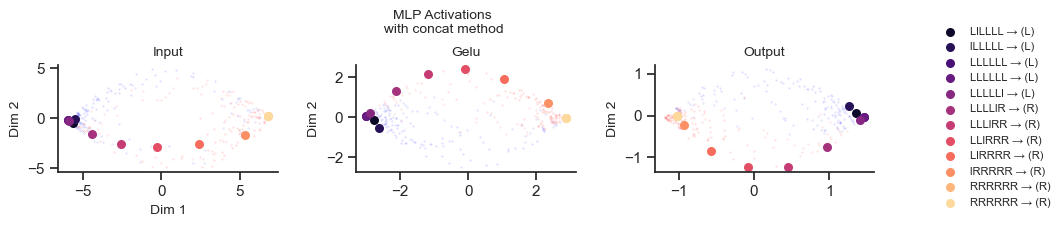

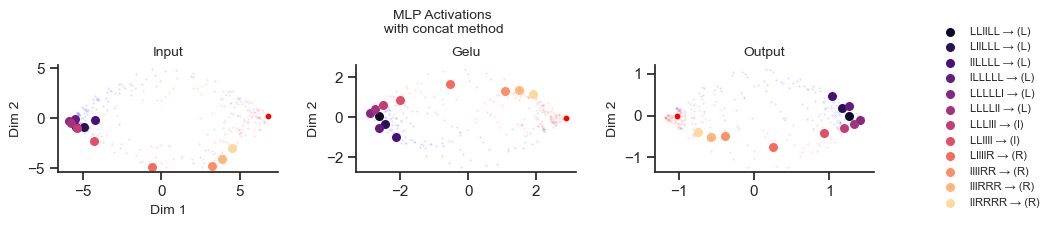

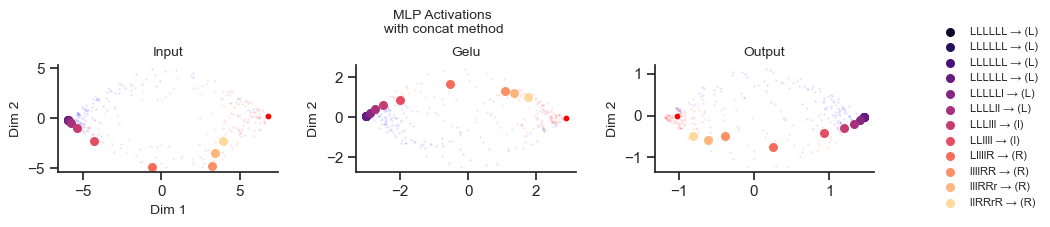

In [49]:
dr_config = DimensionalityReductionConfig(
    token_pos=-1,
    sequence_method='concat',
    n_components=2
)

for i, seq in enumerate(block_sequences[10:14], start=10):
    fig,axs = analyzer.visualizer.plot_pca_across_trials(sequences, seq, ['input', 'gelu', 'output'], dr_config)
    fig_path = fm.get_experiment_file(f'mlp_pca_concat.png', run, subdir=f'interp/bt_{i}')
    fig.savefig(fig_path, bbox_inches='tight')
    

# 6. Correlation Matrix between Neurons

In [61]:
import interp_helpers as interp

/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/interp_helpers.py:378: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Process a model to extract its token embeddings."""
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/interp_helpers.py:378: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Process a model to extract its token embeddings."""
/Users/celiaberon/GitHub/Transformers_for_Modeling_Decision_Sequences/interpretability/interp_helpers.py:378: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Process a model to extract its token embeddings."""


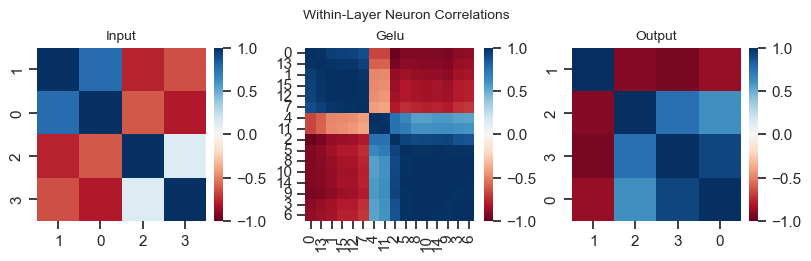

In [65]:
fig, axs = plt.subplots(ncols=3,figsize=(8, 2.5), layout='constrained')
for ax, layer in zip(axs, analyzer.layers):

    # Calculate correlation between neurons (input layer)
    neuron_corr = pd.DataFrame(last_pos_by_layer[layer]).T.corr()

    ordered_sequences, ordered_sim_matrix, Z_ordered = interp.cluster_sequences_hierarchical(neuron_corr.to_numpy(), np.arange(len(neuron_corr)), replot=False, is_similarity=True)
    interp.plot_similarity(ordered_sim_matrix, ordered_sequences, ax=ax)
    ax.set_title(layer.capitalize())

fig.suptitle("Within-Layer Neuron Correlations")
fig_path = fm.get_experiment_file('mlp_interneuron_corr.png', run, subdir='interp')
# fig.savefig(fig_path, bbox_inches='tight')

# 7. Probing to find maximal activation across layers

In [53]:
events, sequences, counts = interp.get_common_sequences(T, events=events, k=1000)
activations = analyzer.get_activations(sequences)
last_pos_by_layer = analyzer.get_activation_by_position(activations, token_pos=-1)

In [56]:
# Find maximal activations for each layer
max_activations = {}
for layer_name in analyzer.layers:
    max_activations[layer_name] = analyzer.find_maximal_activations(
        last_pos_by_layer, layer_name, sequences)
    
    # Print example results for a few neurons
    print(f"\n{layer_name.upper()} LAYER - Top activating sequences:")
    for neuron_idx in range(min(5, len(max_activations[layer_name]))):  # Show first 5 neurons
        print(f"Neuron {neuron_idx}: ", end="")
        for seq, act in max_activations[layer_name][neuron_idx][:5]:
            print(f"{seq} ({act:.3f})", end=" | ")
        print()


INPUT LAYER - Top activating sequences:
Neuron 0: RRRRRR (1.133) | RlRRRR (1.127) | RRlRRR (1.123) | RRRlRR (1.122) | RRRRlR (1.121) | 
Neuron 1: RRRrrl (2.068) | RRrRrl (2.066) | RRrrRl (2.064) | RrRRrl (2.063) | RrRrRl (2.061) | 
Neuron 2: LLLLLr (2.191) | LLLLrr (2.181) | LLLrLr (2.179) | LLrLLr (2.175) | LrLLLr (2.170) | 
Neuron 3: RRRRRL (1.737) | RRRRlL (1.687) | RRRllL (1.630) | RRlllL (1.578) | RllllL (1.544) | 

GELU LAYER - Top activating sequences:
Neuron 0: lLlllL (0.161) | llLllL (0.161) | lllLlL (0.161) | llllLL (0.161) | LllllL (0.161) | 
Neuron 1: lllllL (0.382) | lLlllL (0.376) | LllllL (0.376) | llLllL (0.375) | lllLlL (0.375) | 
Neuron 2: lLlllR (0.975) | llllLR (0.975) | lllLlR (0.975) | llLllR (0.975) | rrlllR (0.975) | 
Neuron 3: rrrrRR (0.364) | rrrRrR (0.364) | rrRrrR (0.364) | rLLllR (0.363) | LLRRRR (0.363) | 
Neuron 4: RRRRRR (0.752) | RlRRRR (0.747) | RRlRRR (0.741) | RRRlRR (0.739) | RRRRlR (0.738) | 

OUTPUT LAYER - Top activating sequences:
Neuron 0: lll

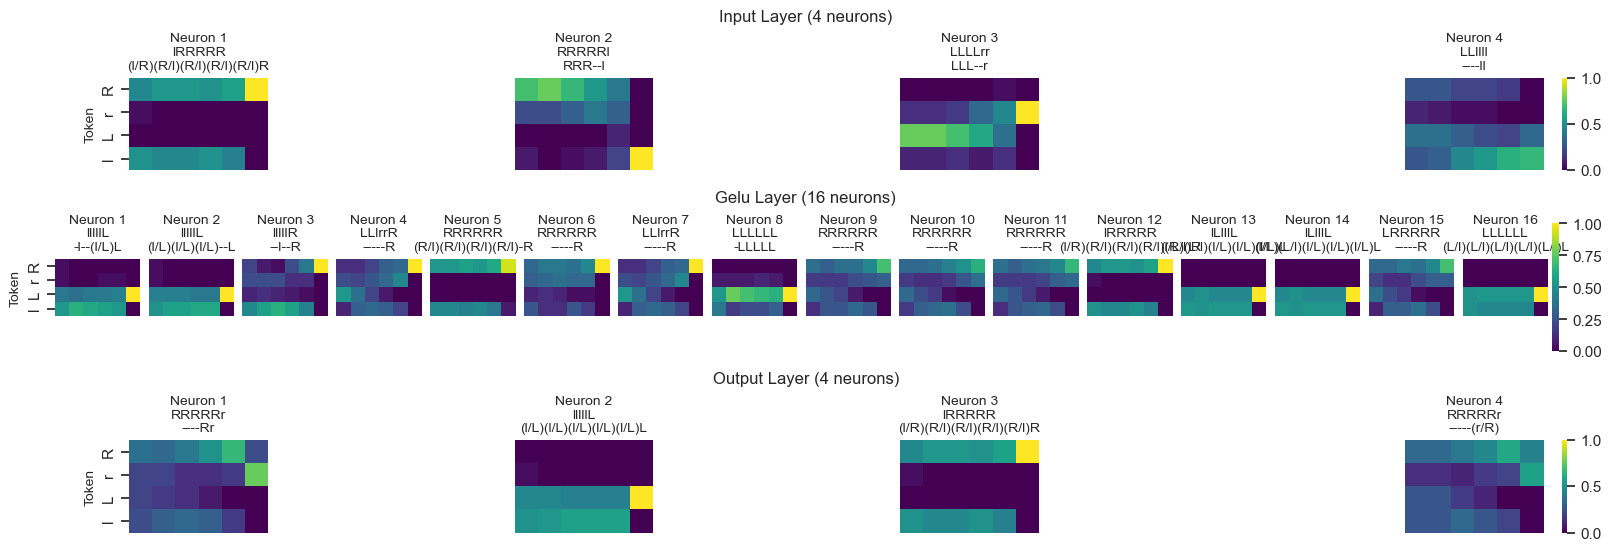

In [57]:
fig, axes_dict = analyzer.visualizer.create_mlp_visualization()

for layer_name, axes in axes_dict.items():

    for neuron_idx, ax in enumerate(axes):
        ax, token_counts = analyzer.analyze_neuron_patterns(max_activations, layer_name, neuron_idx, ax=ax, cbar=neuron_idx == (len(axes)-1))
        avg_sequence = analyzer.get_average_sequence(token_counts, single_threshold=0, joint_threshold=0)
        avg_sequence_thresholded = analyzer.get_average_sequence(token_counts, single_threshold=0.6, joint_threshold=0.4)
        ax.set(title=f"Neuron {neuron_idx+1}\n{avg_sequence}\n{avg_sequence_thresholded}", xticks=[])
        ax.set_aspect(1)
        if neuron_idx > 0:
            ax.set(ylabel='', yticks=[])
        ax.set(xlabel='')
fig_path = fm.get_experiment_file('mlp_max_activations.png', run, subdir='interp')
fig.savefig(fig_path, bbox_inches='tight')

# 8. Probing by Generating Synthetic Inputs

In [26]:
# def generate_maximal_input(layer_name, neuron_idx, iterations=100, lr=0.1):
#     """Generate a synthetic input that maximally activates a specific neuron"""
#     # Create a soft representation of a sequence (probabilities over vocabulary)
#     sequence_length = 6  # Same as our training sequences
    
#     # Initialize with uniform probabilities - properly create a leaf tensor
#     token_probs = torch.ones((sequence_length, len(vocab)), device=device) / len(vocab)
#     token_probs = token_probs.clone().detach().requires_grad_(True)  # Make it a proper leaf tensor
    
#     # Create optimizer
#     optimizer = torch.optim.Adam([token_probs], lr=lr)
    
#     # Optimization loop
#     activation_history = []
    
#     for i in range(iterations):
#         optimizer.zero_grad()
        
#         # Generate a soft one-hot encoding of the sequence
#         soft_tokens = F.gumbel_softmax(token_probs, tau=1.0, hard=False, dim=-1)
        
#         # Create embeddings from soft tokens - fix the matrix multiplication
#         # Get embedding dimension
#         embed_dim = model.transformer.wte.weight.shape[1]
        
#         # Initialize an empty tensor for the embeddings
#         token_embeds = torch.zeros((sequence_length, embed_dim), device=device)
        
#         # For each position, compute the weighted sum of embeddings
#         for pos in range(sequence_length):
#             for token_idx in range(len(vocab)):
#                 token_embeds[pos] += soft_tokens[pos, token_idx] * model.transformer.wte.weight[token_idx]
        
#         # Add position embeddings
#         pos = torch.arange(0, sequence_length, dtype=torch.long, device=device)
#         pos_embeds = model.transformer.wpe(pos)
#         x = token_embeds + pos_embeds
        
#         # Add batch dimension
#         x = x.unsqueeze(0)
        
#         # Forward through the model layers until the target layer
#         if layer_name == 'input':
#             # Input to MLP is after attention and layer norm
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 target_activation = block.ln_2(x)[0, -1, neuron_idx]
#                 break
                
#         elif layer_name == 'hidden':
#             # Hidden layer is after first linear layer in MLP
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 ln_2_out = block.ln_2(x)
#                 target_activation = block.mlp.c_fc(ln_2_out)[0, -1, neuron_idx]
#                 break
                
#         elif layer_name == 'gelu':
#             # After GELU activation
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 ln_2_out = block.ln_2(x)
#                 fc_out = block.mlp.c_fc(ln_2_out)
#                 target_activation = block.mlp.gelu(fc_out)[0, -1, neuron_idx]
#                 break
                
#         elif layer_name == 'output':
#             # Output of MLP
#             for block in model.transformer.h:
#                 ln_1_out = block.ln_1(x)
#                 attn_out = block.attn(ln_1_out)
#                 x = x + attn_out
#                 ln_2_out = block.ln_2(x)
#                 mlp_out = block.mlp(ln_2_out)
#                 target_activation = mlp_out[0, -1, neuron_idx]
#                 break
        
#         # Maximize the target activation
#         loss = -target_activation
#         loss.backward()
#         optimizer.step()
        
#         # Record activation value
#         activation_history.append(target_activation.item())
        
#         # Ensure probabilities sum to 1
#         with torch.no_grad():
#             token_probs.data = F.softmax(token_probs.data, dim=-1)
    
#     # Convert soft tokens to most likely sequence
#     with torch.no_grad():
#         best_tokens = torch.argmax(token_probs, dim=-1).cpu().numpy()
#     best_sequence = ''.join([vocab[idx] for idx in best_tokens])
    
#     # Find the iteration with the highest activation
#     best_iteration = np.argmax(activation_history)
#     best_activation = activation_history[best_iteration]
    
#     # Visualize token probabilities for the optimized sequence
#     token_probs_np = token_probs.detach().cpu().numpy()
    
#     plt.figure(figsize=(12, 8))
    
#     # Plot final activation achieved
#     plt.subplot(2, 1, 1)
#     plt.plot(activation_history)
#     plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best at iteration {best_iteration}')
#     plt.title(f'Neuron Activation Over Optimization ({layer_name} layer, neuron {neuron_idx})')
#     plt.xlabel('Iteration')
#     plt.ylabel('Activation')
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.legend()
    
#     # Plot token probabilities for each position
#     plt.subplot(2, 1, 2)
#     sns.heatmap(token_probs_np, annot=True, fmt='.2f', cmap='viridis',
#                 xticklabels=vocab, yticklabels=range(sequence_length))
#     plt.title(f'Optimized Token Probabilities (Best sequence: {best_sequence})')
#     plt.xlabel('Token')
#     plt.ylabel('Position')
    
#     plt.tight_layout()
#     plt.show()
    
#     return best_sequence, token_probs_np, activation_history, best_iteration, best_activation

# # Choose specific neurons to probe from different layers
# for layer_name in ['input', 'hidden', 'gelu', 'output']:
#     # Since max_activations may not be available, choose a fixed neuron index
#     # For hidden layer (dimension 32), try neuron 5
#     # For output layer (dimension 8), try neuron 2
#     if layer_name == 'hidden':
#         neuron_idx = 5  # Or any index < 32 (hidden dimension)
#     else:  # 'output'
#         neuron_idx = 2  # Or any index < 8 (output dimension)
    
#     print(f"\nGenerating maximal input for {layer_name} layer, neuron {neuron_idx}...")
#     best_seq, probs, history, best_iter, best_act = generate_maximal_input(layer_name, neuron_idx)
#     print(f"Best sequence: {best_seq}")
#     print(f"Best iteration: {best_iter}")
#     print(f"Best activation: {best_act:.4f}")

# 9. MLP Layer Interp

In [16]:
# sequences = vc[vc > 50].index.tolist()[:50]

# detailed_activations = {}
# for seq in sequences:
#     detailed_activations[seq] = get_mlp_detailed_activations(model, seq, vocab, stoi)
# last_pos_by_layer = {
#     layer_name: {
#         seq: detailed_activations[seq][layer_name][0][0, -1, :] 
#         for seq in sequences
#     }
#     for layer_name in ['input', 'hidden', 'gelu', 'output']
# }

In [36]:

def compare_layer_representations(activations_by_layer, layers=None):
    """Compare how representations evolve through the MLP layers"""
    
    if layers is None:
        layers = ['input', 'gelu', 'output']
    
    # Get activations from all layers
    all_activations = {}
    
    for layer_name in layers:
        # Reshape data to be (n_sequences, n_neurons)
        layer_acts = np.array([activations_by_layer[layer_name][seq] for seq in sequences])
        all_activations[layer_name] = layer_acts
    
    # Compute pairwise correlations between neuron activations in different layers
    layer_correlations = {}
    
    for layer1 in layers:
        for layer2 in layers[1:]:
            if layer1 >= layer2:  # Only compute correlation for layer1 < layer2
                continue
                
            # If dimensions don't match, we need to project to compare
            if all_activations[layer1].shape[1] != all_activations[layer2].shape[1]:
                print(f"Note: {layer1} and {layer2} have different dimensions, using PCA for comparison")
                
                # Use PCA to project to same dimension for comparison
                min_dim = min(all_activations[layer1].shape[1], all_activations[layer2].shape[1])
                pca1 = PCA(n_components=min_dim)
                pca2 = PCA(n_components=min_dim)
                
                proj1 = pca1.fit_transform(all_activations[layer1])
                proj2 = pca2.fit_transform(all_activations[layer2])
                
                # Calculate correlation
                corr = np.corrcoef(proj1.flatten(), proj2.flatten())[0, 1]
            else:
                # Calculate correlation directly
                corr = np.corrcoef(all_activations[layer1].flatten(), 
                                    all_activations[layer2].flatten())[0, 1]
                
            layer_correlations[f"{layer1}-{layer2}"] = corr
    
    print("\nCorrelations between layer representations:")
    for pair, corr in layer_correlations.items():
        print(f"{pair}: {corr:.4f}")

    # fig, axs = plot_pca_by_layer(activations_by_layer, sequences, counts)

compare_layer_representations(last_pos_by_layer)

Note: gelu and output have different dimensions, using PCA for comparison

Correlations between layer representations:
input-output: -0.3434
gelu-output: -0.9258
